In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib PM4Py

In [1]:
# A custom exception class
class MyException(Exception):
    pass

In [2]:
import cv2
import math
import numpy as np
import os
import pm4py
import pandas as pd
from PIL import Image
import numpy as np
import glob
import json
import graphviz
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [3]:
class PatternsConverter():
    
    act_dict = None
    
    @classmethod
    def set_activities_dict(cls, act_dict):
        cls.act_dict = act_dict

    
    def __init__(self, log_file_path, caseID_col_name, act_col_name, ts_col_name):
        self.log_file_path = log_file_path
        # Динамические поля (переменные объекта)
        self.caseID_col_name = caseID_col_name 
        self.act_col_name = act_col_name
        self.ts_col_name = ts_col_name
        
        #self.event_log = pd.read_csv(log_file_path, sep=ch_sep)
        self.event_log = pm4py.read_xes(log_file_path)
        self.event_log[caseID_col_name]=self.event_log[caseID_col_name].apply(str)
        self.event_log[act_col_name]=self.event_log[act_col_name].apply(str)
        self.traces_num = 0
        self.event_log[ts_col_name]= pd.to_datetime(self.event_log[ts_col_name], utc=True, dayfirst=True)
        self.event_log[ts_col_name]= self.event_log[ts_col_name].dt.strftime('%Y-%m-%d %H:%M:%S')
    

        self.event_log = self.event_log[[act_col_name, caseID_col_name, ts_col_name]]
        
        #self.act_freq = [0]*len(PatternsConverter.act_dict)

    def __get_unique_ids(self):
        ids = list(self.event_log[self.caseID_col_name].unique())
        self.traces_num = len(ids)
        return ids

    def __get_case_logs(self, ids_list):
        case_logs = []
        for id in ids_list:
            case_log = self.event_log.query("`{0}` == @id".format(self.caseID_col_name))
            case_log.sort_values(by=[self.ts_col_name])
            if len(case_log) > 2:
                case_logs.append(case_log)
#             for i in range(len(PatternsConverter.act_dict)):
#                 if activities[i] in case_log[self.act_col_name].values:
#                     self.act_freq[i] += 1
                    
#         for i in range(len(PatternsConverter.act_dict)):
#             if self.act_freq[i] != 0:
#                 self.act_freq[i] = math.log2(len(case_logs)/self.act_freq[i])
#         print(self.act_freq)
        return case_logs

    def __get_prefix_traces(self):
        cases_prefix_traces = []
        self.max_len_prefix_trace = 0

        for case_log in self.case_logs:
            prefix_traces_act = []
            for i in range(1, len(case_log) + 1):
                prefix_trace = []
                
                if "pattern_bounded_3_times" not in self.log_file_path:
                    prefix_trace = case_log[self.act_col_name].values[0:i]
                else:
                    prefix_trace = case_log[0:i]
                   
                # находим самую длинную префиксную трассу
                if len(prefix_trace) > self.max_len_prefix_trace:
                    self.max_len_prefix_trace = len(prefix_trace)
                
                
                prefix_traces_act.append(prefix_trace)
                

            cases_prefix_traces.append(prefix_traces_act)
            #print(prefix_traces_act)
        return cases_prefix_traces

    def __get_activity_matrices(self):
        activity_matrices = []
        for prefix_traces in self.cases_prefix_traces:
            np_matrix = []
            matrix = [[0] * len(PatternsConverter.act_dict) for i in range(self.max_len_prefix_trace)]
            for i in range(len(prefix_traces)):
                for act in prefix_traces[i]:
                    act_index = PatternsConverter.act_dict[act]
                    matrix[i][act_index] += 1
            np_matrix = np.asmatrix(matrix)
            np_matrix = np_matrix.astype("uint8")
            activity_matrices.append(np_matrix)
        return activity_matrices

    def convert(self, path_to_dir):
        ids_list = self.__get_unique_ids()

        if "pattern_bounded_3_times" not in self.log_file_path:
            self.case_logs = self.__get_case_logs(ids_list)
        else:
            matrix = [["Start", "Ist", "A", "A", "A", "Icmp", "End"]] * 1000
            self.case_logs = matrix
        
        self.cases_prefix_traces = self.__get_prefix_traces()
        self.activity_matrices = self.__get_activity_matrices()

        index = 1
    
    
#         freq_matrix = [self.act_freq]  * self.max_len_prefix_trace
#         freq_matrix = np.squeeze(np.asarray(freq_matrix))
#         freq_matrix = 255.0/(freq_matrix.max()*2)
#         freq_matrix = np.squeeze(np.asarray(freq_matrix))
#         freq_matrix = freq_matrix.astype(int)
#         print(self.act_freq)
        for np_matrix in self.activity_matrices:
           
            norm_matrix = np_matrix.copy()
            norm_matrix *= 255.0 / norm_matrix.max()
            activity_chanel = np.squeeze(np.asarray(norm_matrix))
            activity_chanel = activity_chanel.astype(int)

            result = cv2.merge([activity_chanel, activity_chanel, activity_chanel])
            path = path_to_dir + "/image_" + str(index) + ".png"

            # resize image
            result = cv2.resize(result, (256, 256), interpolation=cv2.INTER_NEAREST)

            cv2.imwrite(path, result)
            index += 1


In [4]:
class ModelLoader():
    def __init__(self, mode, path_patterns_img_dir, paths_patterns_XES_data=None, 
                 caseID_col_name=None, act_col_name=None, ts_col_name=None):
        
        self.path_patterns_img_dir = path_patterns_img_dir
        self.act_dict = None
        match mode:
            case 0:
                self.paths_patterns_XES_data = paths_patterns_XES_data
            
                # Динамические поля (переменные объекта)
                self.caseID_col_name = caseID_col_name 
                self.act_col_name = act_col_name
                self.ts_col_name = ts_col_name
                self.__convert_data_to_img()
            case 1:
                pass
            case _:
                raise MyException("Wrong mode! Allowed modes are 0 and 1!")
                        
        
    def __convert_data_to_img(self):
        activities = set()
        for path in self.paths_patterns_XES_data:
            log = pm4py.read_xes(path)
            for act in pd.unique(log[self.act_col_name].values.ravel()):
                activities.add(act)
        
        activities = sorted(activities)
        # проводим соответствие между номером и активити
        act_num = len(activities)
        self.act_dict = {}
        for i in range(act_num):
            self.act_dict[activities[i]] = i
        
        PatternsConverter.set_activities_dict(self.act_dict)
        
        for path in self.paths_patterns_XES_data:
            act_conv = PatternsConverter(path, self.caseID_col_name, self.act_col_name, self.ts_col_name)
            name = os.path.basename(path)
            size = len(name)
            path_to_pattern_dir = self.path_patterns_img_dir + "/" + name[:size-4]
            if not os.path.exists(path_to_pattern_dir):
                os.makedirs(path_to_pattern_dir)
            act_conv.convert(path_to_pattern_dir)
        
    def get_act_dict(self):
        if self.act_dict != None:
            return self.act_dict
        else:
            raise MyException("act_dict is not available!")
            
            
    def load_scale_data(self, show_sample):
        self.img_data = tf.keras.utils.image_dataset_from_directory(self.path_patterns_img_dir)
        self.class_names = self.img_data.class_names
        
        if show_sample:
            data_iterator = self.img_data.as_numpy_iterator()
            batch = data_iterator.next()
            fig, ax = plt.subplots(ncols=4, figsize=(20,20))
            for idx, img in enumerate(batch[0][:4]):
                ax[idx].imshow(img.astype(int))
                ax[idx].title.set_text(batch[1][idx])
                
        self.img_data = self.img_data.map(lambda x,y: (x/255, y))
        if show_sample:
            self.img_data.as_numpy_iterator().next()
    
    def split_data(self, train_size_prop, val_size_prop, test_size_prop):
        
        arr = np.array([train_size_prop, val_size_prop, test_size_prop])

        if (arr >= 0).all() and (arr <= 1).all() and int(sum(arr)+0.01) == 1:
            train_size = int(len(self.img_data)*train_size_prop)
            val_size = int(len(self.img_data)*val_size_prop)
            test_size = int(len(self.img_data)*test_size_prop)
            print("Whole data size is " + str(len(self.img_data)) + "\nTraining data size is " + str(train_size))
            
            self.train = self.img_data.take(train_size)
            self.val = self.img_data.skip(train_size).take(val_size)
            self.test = self.img_data.skip(train_size+val_size).take(test_size)
        else:
            raise MyException("Some of the proportions are out of range!")
            
    def __build_model(self):
        self.model = Sequential()
        num_classes = len(self.img_data)

        self.model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(2,2))
        
        self.model.add(Conv2D(32, (3,3), 1, activation='relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(Conv2D(16, (3,3), 1, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2,2)))
        
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(4, activation='softmax'))
        
        self.model.compile(optimizer=Adam(learning_rate=1e-06), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    def __train_model(self, number_epochs, add_data_autotune):
        
        if add_data_autotune:
            AUTOTUNE = tf.data.AUTOTUNE
            self.train = self.train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
            self.val = self.val.cache().prefetch(buffer_size=AUTOTUNE)
            
        logdir='logs'
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
        
        self.hist = self.model.fit(self.train, epochs = number_epochs, validation_data=self.val, callbacks=[tensorboard_callback])
    
    def plot_model_performance(self):
        fig = plt.figure()
        plt.plot(self.hist.history['loss'], color='teal', label='loss')
        plt.plot(self.hist.history['val_loss'], color='orange', label='val_loss')
        fig.suptitle('Loss', fontsize=20)
        plt.legend(loc="upper left")
        plt.show()
        
        fig = plt.figure()
        plt.plot(self.hist.history['accuracy'], color='teal', label='accuracy')
        plt.plot(self.hist.history['val_accuracy'], color='orange', label='val_accuracy')
        fig.suptitle('Accuracy', fontsize=20)
        plt.legend(loc="upper left")
        plt.show()
        
    def model_summary(model):
        print(model.summary())
    
    def create_model(self, number_epochs, add_data_autotune):
        self.__build_model()
        self.__train_model(number_epochs, add_data_autotune)
        return (self.model, (self.act_dict, self.class_names))
    
    def get_class_names():
        return self.class_names
    
    @classmethod
    def save_model(cls, model, path_to_model_dir, model_name, info_data, path_to_info_dir, model_info_name):
        model_path = os.path.join(path_to_model_dir, model_name + ".h5")
        if os.path.isfile(model_path) is False:
            model.save(model_path)

            info_path = os.path.join(path_to_info_dir, model_info_name + ".json")
            data = (model_path, info_data)
            with open(info_path, 'w') as f:
                json.dump(data, f)
        else:
            raise MyException("Model with such name already exists!")
        
    @classmethod
    def load_built_model(cls, path_to_info_data):
        data = ()
        with open(path_to_info_data, 'r') as f:
            data = json.load(f)
        
        return data

In [5]:
class LogConverter():
    
    act_dict = None
    
    @classmethod
    def set_activities_dict(cls, act_dict):
        cls.act_dict = act_dict
       
    
    def __init__(self, log_file_path, caseID_col_name, act_col_name, ts_col_name):
        self.log_file_path = log_file_path
        # Динамические поля (переменные объекта)
        self.caseID_col_name = caseID_col_name 
        self.act_col_name = act_col_name
        self.ts_col_name = ts_col_name

        #self.event_log = pd.read_csv(log_file_path, sep=ch_sep)
        self.event_log = pm4py.read_xes(log_file_path)
        self.event_log[caseID_col_name]=self.event_log[caseID_col_name].apply(str)
        self.event_log[act_col_name]=self.event_log[act_col_name].apply(str)
        self.traces_num = 0
        self.event_log[ts_col_name]= pd.to_datetime(self.event_log[ts_col_name], utc=True, dayfirst=True)
        self.event_log[ts_col_name]= self.event_log[ts_col_name].dt.strftime('%Y-%m-%d %H:%M:%S')

        self.event_log = self.event_log[[act_col_name, caseID_col_name, ts_col_name]]
        
    
    def __get_unique_ids(self):
        ids = list(self.event_log[self.caseID_col_name].unique())
        self.traces_num = len(ids)
        return ids

    def __get_case_logs(self, ids_list):
        case_logs = []
        for id in ids_list:
            #case_log = self.event_log.query("`{0}` == @id".format(self.caseID_col_name))
            case_log = self.event_log[self.event_log[self.caseID_col_name] == id]
            case_log.sort_values(by=[self.ts_col_name])
            if len(case_log) > 2:
                case_logs.append(case_log)
           
        return case_logs

    def __get_prefix_traces(self):
        cases_prefix_traces = []
        self.max_len_prefix_trace = 0

        for case_log in self.case_logs:
            prefix_traces_act = []
            trace = list(case_log.to_records(index=False)[1:].tolist())
            
            for i in range(1, len(case_log) + 1):
                prefix_trace = case_log[self.act_col_name].values[0:i]
                
                # находим самую длинную префиксную трассу
                if len(prefix_trace) > self.max_len_prefix_trace:
                    self.max_len_prefix_trace = len(prefix_trace)
                
                
                prefix_traces_act.append(prefix_trace)
                

            cases_prefix_traces.append((prefix_traces_act, trace))
            #print(prefix_traces_act)
        return cases_prefix_traces

    def __get_activity_matrices(self):
        activity_matrices = []
        for prefix_traces, trace in self.cases_prefix_traces:
            np_matrix = []
            matrix = [[0] * len(LogConverter.act_dict) for i in range(self.max_len_prefix_trace)]
            for i in range(len(prefix_traces)):
                for act in prefix_traces[i]:
                    act_index = LogConverter.act_dict[act]
                    matrix[i][act_index] += 1
            np_matrix = np.asmatrix(matrix)
            np_matrix = np_matrix.astype("uint8")
            activity_matrices.append((np_matrix, trace))
        return activity_matrices
    
    def convert(self, path_to_img_dir, log_data_json_path):
        ids_list = self.__get_unique_ids()
        self.case_logs = self.__get_case_logs(ids_list)
        
        self.cases_prefix_traces = self.__get_prefix_traces()
        self.activity_matrices = self.__get_activity_matrices()

        index = 1

        tuple_data = []
        for np_matrix, trace in self.activity_matrices:
            norm_matrix = np_matrix.copy()
            norm_matrix *= 255.0 / norm_matrix.max()
            activity_chanel = np.squeeze(np.asarray(norm_matrix))
            activity_chanel = activity_chanel.astype(int)

            result = cv2.merge([activity_chanel, activity_chanel, activity_chanel])
            path = path_to_img_dir + "/image_" + str(index) + ".png"

            # resize image
            result = cv2.resize(result, (256, 256), interpolation=cv2.INTER_NEAREST)

            cv2.imwrite(path, result)

            pair = (path, list(trace))
            tuple_data.append(pair)

            index += 1
            
        with open(log_data_json_path, 'w') as f:
            json.dump(tuple_data, f)

In [6]:
class LogLoader:
    def __init__(self, mode, log_data_json_path, act_dict = None, log_file_path=None, 
                 path_to_img_dir = None, caseID_col_name=None, act_col_name=None,
                 ts_col_name=None):
        
        self.log_data_json_path = log_data_json_path
        self.act_dict = None
        self.img_trace_data = None
        
        match mode:
            case 0:
                # Динамические поля (переменные объекта)
                self.log_file_path = log_file_path
                self.caseID_col_name = caseID_col_name 
                self.act_col_name = act_col_name
                self.ts_col_name = ts_col_name
                self.path_to_img_dir = path_to_img_dir
                self.act_dict = act_dict
                self.__convert_data()
            case 1:
                # Read data from JSON file
                with open(self.log_data_json_path, "r") as f:
                    self.img_trace_data = json.load(f)
    
    def __convert_data(self):        
        LogConverter.set_activities_dict(self.act_dict)
        
        log_conv = LogConverter(self.log_file_path, self.caseID_col_name, self.act_col_name, self.ts_col_name)
        log_conv.convert(self.path_to_img_dir, self.log_data_json_path)
        # Read data from JSON file
        with open(self.log_data_json_path, "r") as f:
            self.img_trace_data = json.load(f)
                    
    def get_img_trace_data(self):
        if (self.img_trace_data != None):
            return self.img_trace_data

In [7]:
xes_data = ['data_3/XES_NETS/pattern_between_after_before.xes',
           'data_3/XES_NETS/pattern_bounded_3_times.xes',
           'data_3/XES_NETS/pattern_exist_act_uni.xes',
           'data_3/XES_NETS/pattern_response_direct.xes']

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

Found 2955 files belonging to 4 classes.
Whole data size is 93
Training data size is 65
Epoch 1/10
65/65 [==============================] - 74s 1s/step - loss: 1.0484 - accuracy: 0.6596 - val_loss: 1.3110 - val_accuracy: 0.3299
Epoch 2/10
65/65 [==============================] - 71s 1s/step - loss: 0.2660 - accuracy: 0.9125 - val_loss: 1.2257 - val_accuracy: 0.3299
Epoch 3/10
65/65 [==============================] - 84s 1s/step - loss: 0.1250 - accuracy: 0.9591 - val_loss: 1.0644 - val_accuracy: 0.4271
Epoch 4/10
65/65 [==============================] - 81s 1s/step - loss: 0.0697 - accuracy: 0.9817 - val_loss: 0.8291 - val_accuracy: 0.8472
Epoch 5/10
65/65 [==============================] - 73s 1s/step - loss: 0.0457 - accuracy: 0.9894 - val_loss: 0.5301 - val_accuracy: 0.9583
Epoch 6/10
65/65 [==============================] - 80s 1s/step - loss: 0.0453 - accuracy: 0.9885 - val_loss: 0.2735 - val_accuracy: 1.0000
Epoch 7/10
65/65 [==============================] - 71s 1s/step - loss: 

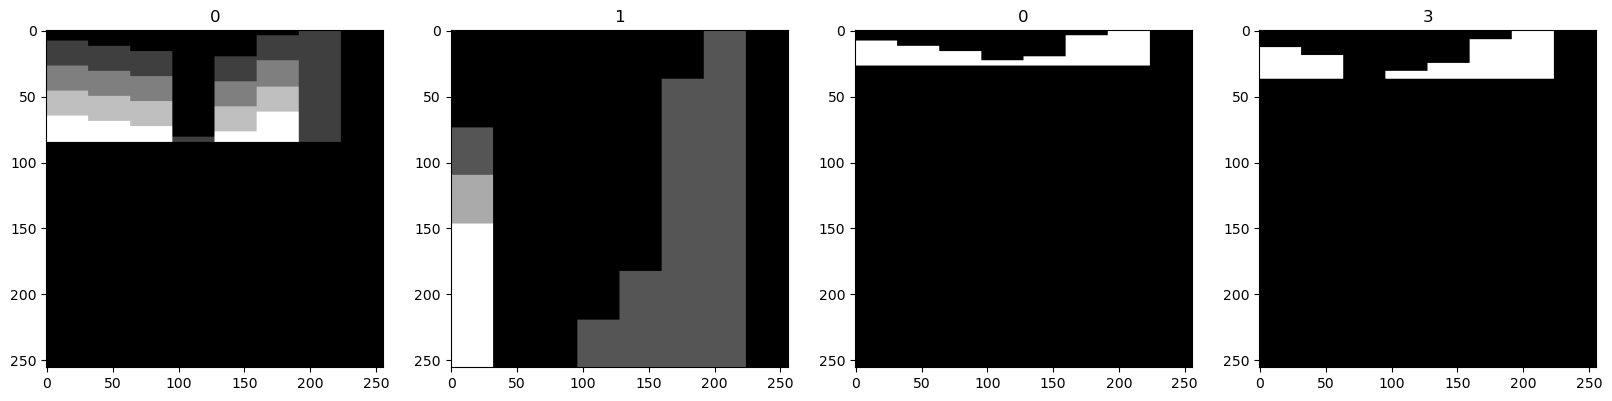

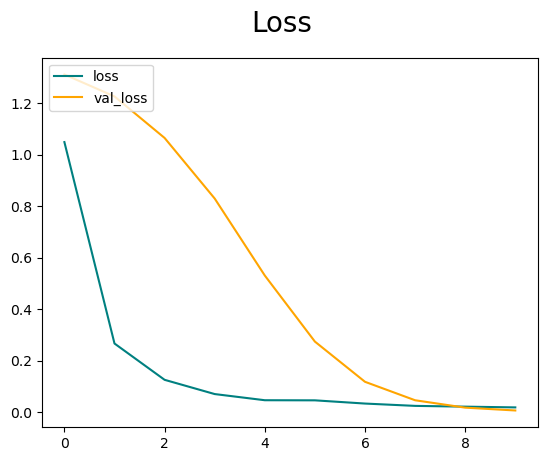

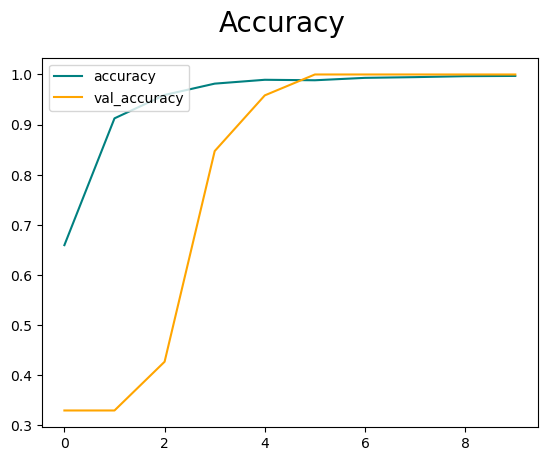

In [9]:
model_loader = ModelLoader(0, 'data_3/patterns', xes_data, "concept:instance", "concept:name", "time:timestamp")

model_loader.load_scale_data(True)
model_loader.split_data(0.7, 0.2, 0.1)
model, info_data = model_loader.create_model(10, True)
ModelLoader.save_model(model, "models", "model_14-1", info_data, "info_data", "info_data_14-1")
model_loader.plot_model_performance()

In [10]:
info_data

({'A': 0, 'B': 1, 'C': 2, 'End': 3, 'Icmp': 4, 'Ist': 5, 'Start': 6, 'T': 7},
 ['pattern_between_after_before',
  'pattern_bounded_3_times',
  'pattern_exist_act_uni',
  'pattern_response_direct'])

In [7]:
model_data = ModelLoader.load_built_model('info_data/info_data_14-1.json')
model = load_model(model_data[0])
#model = load_model("models/pattern_model_8.h5")
act_dict = model_data[1][0]
class_names = model_data[1][1]
print(act_dict)

{'A': 0, 'B': 1, 'C': 2, 'End': 3, 'Icmp': 4, 'Ist': 5, 'Start': 6, 'T': 7}


In [8]:
log_loader = LogLoader(0, "data_3/JSON/data.json", act_dict, "data_3/XES_NETS/test_net_1_RD_BetwAB_patterns.xes", "data_3/Log_Images_Bound3T_EAU", "concept:instance", "concept:name", "time:timestamp")
#log_loader = LogLoader(1, "data_3/JSON/data.json")

data = log_loader.get_img_trace_data()

C:\Users\Максим\AppData\Roaming\Python\Python310\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
classes = {}
for img_path, trace in data:
    image = cv2.imread(img_path)
    resize = tf.image.resize(image, (256,256))
    yhat = model.predict(np.expand_dims(resize/255, 0), verbose = 0)
    img_pattern_class = class_names[np.argmax(yhat)]
    if (np.max(yhat) > 0.85):
        if img_pattern_class not in classes:
            classes[img_pattern_class] = trace
        classes[img_pattern_class] + trace
    #print(np.max(yhat), class_names[np.argmax(yhat)])

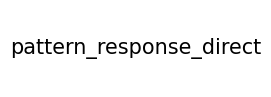

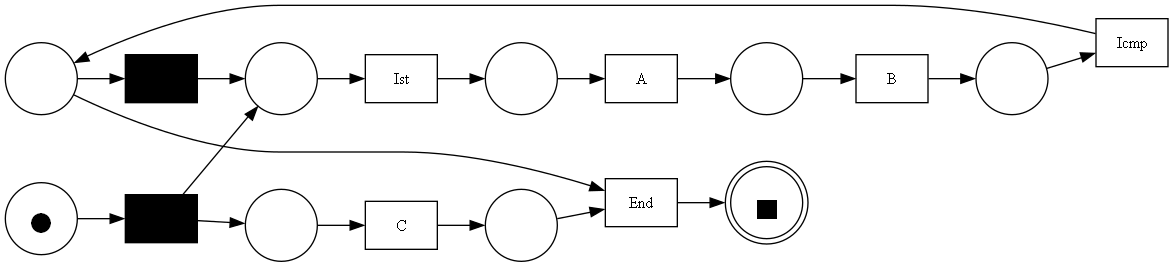

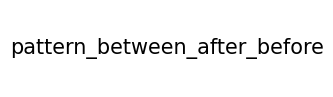

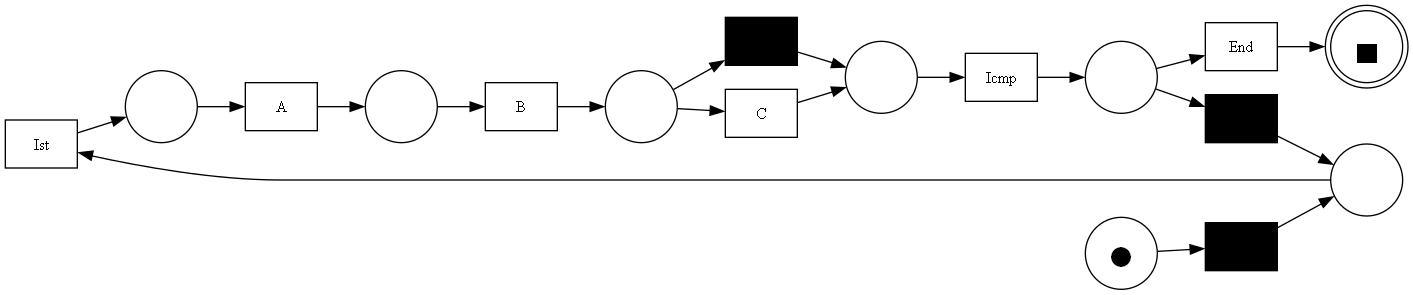

In [15]:
%%capture --no-display
for key in classes:
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.axis('off')
    ax.text(0.1, 0.5, key, ha='center', va='center', fontsize=15)
    plt.show()
    log = pd.DataFrame(classes[key])
    log[2] = pd.to_datetime(log[2])
    log.columns = ['Activity_Name', 'CaseID', 'CompleteTimestamp']
    format_df = pm4py.format_dataframe(log, case_id = 'CaseID', activity_key = 'Activity_Name', timestamp_key = 'CompleteTimestamp')
    event_log = pm4py.convert_to_event_log(format_df)
    net, im, fm = pm4py.discover_petri_net_inductive(event_log)
    pm4py.view_petri_net(net, im, fm, format = 'png')

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 254, 254, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_4 (Batc  (None, 125, 125, 32)     128       
 hNormalization)                                                 
                                                      

In [20]:
classes

{}